In [1]:
# !pip install --upgrade --force-reinstall "git+https://github.com/nbukhanchenko/transtimegrad"

In [2]:
%matplotlib inline

from diffusers import DEISMultistepScheduler
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import MultivariateEvaluator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
LIB_PATH = "~/Desktop/THESIS/transtimegrad"
os.chdir(os.path.expanduser(LIB_PATH))
from ttg.model.__trans_timegrad import TransTimeGradEstimator

/opt/homebrew/anaconda3/envs/sandbox/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/opt/homebrew/anaconda3/envs/sandbox/lib/python3.10/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/opt/homebrew/anaconda3/envs/sandbox/lib/python3.10/site-packages/gluonts/dataset/artificial/_base.py:84: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  self.freq: BaseOffset = to_offset(freq)


ModuleNotFoundError: No module named 'pts'

In [3]:
def alpha_for_percentile(p):
    return (p / 100.0) ** 0.3

def plot(
    target,
    forecast,
    prediction_length,
    prediction_intervals=(50.0, 90.0),
    color="g",
    fname=None,
):
    label_prefix = ""
    rows = 4
    cols = 4
    fig, axs = plt.subplots(rows, cols, figsize=(24, 24))
    axx = axs.ravel()
    seq_len, target_dim = target.shape

    ps = [50.0] + [
        50.0 + f * c / 2.0 for c in prediction_intervals for f in [-1.0, +1.0]
    ]

    percentiles_sorted = sorted(set(ps))

    for dim in range(0, min(rows * cols, target_dim)):
        ax = axx[dim]

        target[-2 * prediction_length :][dim].plot(ax=ax)

        ps_data = [forecast.quantile(p / 100.0)[:, dim] for p in percentiles_sorted]
        i_p50 = len(percentiles_sorted) // 2

        p50_data = ps_data[i_p50]
        p50_series = pd.Series(data=p50_data, index=forecast.index)
        p50_series.plot(color=color, ls="-", label=f"{label_prefix}median", ax=ax)

        for i in range(len(percentiles_sorted) // 2):
            ptile = percentiles_sorted[i]
            alpha = alpha_for_percentile(ptile)
            ax.fill_between(
                forecast.index,
                ps_data[i],
                ps_data[-i - 1],
                facecolor=color,
                alpha=alpha,
                interpolate=True,
            )
            # Hack to create labels for the error intervals.
            # Doesn't actually plot anything, because we only pass a single data point
            pd.Series(data=p50_data[:1], index=forecast.index[:1]).plot(
                color=color,
                alpha=alpha,
                linewidth=10,
                label=f"{label_prefix}{100 - ptile * 2}%",
                ax=ax,
            )

    legend = ["observations", "median prediction"] + [
        f"{k}% prediction interval" for k in prediction_intervals
    ][::-1]
    axx[0].legend(legend, loc="upper left")

    if fname is not None:
        plt.savefig(fname, bbox_inches="tight", pad_inches=0.05)

def prepare_dataset(dataset_name):
    dataset = get_dataset(dataset_name, regenerate=False)

    train_grouper = MultivariateGrouper(
        max_target_dim=int(dataset.metadata.feat_static_cat[0].cardinality)
    )
    test_grouper = MultivariateGrouper(
        num_test_dates=int(len(dataset.test) / len(dataset.train)),
        max_target_dim=int(dataset.metadata.feat_static_cat[0].cardinality),
    )

    return {
        "train": train_grouper(dataset.train),
        "test": test_grouper(dataset.test),
        "metadata": dataset.metadata
    }

# lags_seq in (None, [1], [1, 2, 3, 4, 5, 6, 7])
def prepare_predictor(dataset, max_epochs=40,
                      num_train_timesteps=100, beta_start=1e-4, beta_end=0.1, beta_schedule="linear",
                      context_length_coef=3, num_layers=2, hidden_size=64, lr=1e-3, weight_decay=1e-8, dropout_rate=0.1,
                      lags_seq=[1, 7, 14, 24, 168], num_inference_steps=99, batch_size=64, num_batches_per_epoch=100):
    scheduler = DEISMultistepScheduler(
        num_train_timesteps=num_train_timesteps,
        beta_start=beta_start,
        beta_end=beta_end,
        beta_schedule=beta_schedule,
    )

    estimator = TimeGradEstimator(
        freq=dataset["metadata"].freq,
        prediction_length=dataset["metadata"].prediction_length,
        input_size=int(dataset["metadata"].feat_static_cat[0].cardinality),
        scheduler=scheduler,
        context_length=context_length_coef*dataset["metadata"].prediction_length,
        num_layers=num_layers,
        hidden_size=hidden_size,
        lr=lr,
        weight_decay=weight_decay,
        dropout_rate=dropout_rate,
        scaling="mean",
        lags_seq=lags_seq,
        num_inference_steps=num_inference_steps,
        batch_size=batch_size,
        num_batches_per_epoch=num_batches_per_epoch,
        trainer_kwargs=dict(max_epochs=max_epochs, accelerator="gpu", devices="1"),
    )

    return estimator.train(
        training_data=dataset["train"],
        # validation_data=dataset["test"],
        cache_data=True,
        shuffle_buffer_length=1024,
    )

def prepare_metrics(dataset, predictor, num_samples=5):
    evaluator = MultivariateEvaluator(
        quantiles=(np.arange(20) / 20.0)[1:], target_agg_funcs={"sum": np.sum}
    )

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset["test"], predictor=predictor, num_samples=num_samples
    )
    forecasts, targets = list(forecast_it), list(ts_it)
    agg_metric, _ = evaluator(targets, forecasts, num_series=len(dataset["test"]))

    return forecasts, targets, agg_metric

def prepare_statistics(dataset, forecasts, targets, agg_metric):
    metrics = {
        "CRPS": "mean_wQuantileLoss",
        "ND": "ND",
        "NRMSE": "NRMSE",
        "MSE": "MSE"
    }

    for name in metrics:
        print(f"{name}: {round(agg_metric[metrics[name]], 4)}")
        print(f"{name + '-Sum'}: {round(agg_metric['m_sum_' + metrics[name]], 4)}")
        print("-" * 64)

    plot(
        target=targets[0],
        forecast=forecasts[0],
        prediction_length=dataset["metadata"].prediction_length,
    )
    plt.show()

In [4]:
# use different types of schedulers
# check different trainer_kwargs
HYPERPARAMETERS = {
    "max_epochs":            [64, 128, 256, 512],
    "num_train_timesteps":   [50, 100, 150, 200, 250],       # explore
    "beta_start":            [1e-4],
    "beta_end":              [0.1],
    "beta_schedule":         ["linear"],                     # explore
    "context_length_coef":   [1, 2, 3, 4, 5],                # explore
    "num_layers":            [2, 3, 5],                      # explore
    "hidden_size":           [32, 64, 128],                  # explore
    "lr":                    [1e-5, 3e-5, 1e-4, 3e-4, 1e-3], # explore
    "weight_decay":          [1e-9, 1e-8, 1e-7],
    "dropout_rate":          [0.0, 0.05, 0.1, 0.15, 0.2],
    "lags_seq":              [None, [1]],                    # explore
    "num_inference_steps":   [49, 99, 149, 199, 249],
    "batch_size":            [32, 64, 128],
    "num_batches_per_epoch": [32, 64, 128],
    "num_samples":           [50, 100, 200]
}

In [ ]:
datasets = {
    "solar_nips": [],
    # "electricity_nips": [],
    # "exchange_rate_nips": []
}

for dataset_name in datasets:
    dataset = prepare_dataset(dataset_name)
    predictor = prepare_predictor(dataset)
    forecasts, targets, agg_metric = prepare_metrics(dataset, predictor)
    datasets[dataset_name] = {
        "dataset": dataset,
        "predictor": predictor,
        "forecasts": forecasts,
        "targets": targets,
        "agg_metric": agg_metric,
    }

/opt/homebrew/anaconda3/envs/sandbox/lib/python3.10/site-packages/gluonts/dataset/common.py:262: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  return pd.Period(val, freq)


CRPS: 1.3744
CRPS-Sum: 1.4161
----------------------------------------------------------------
ND: 1.5826
ND-Sum: 1.5022
----------------------------------------------------------------
NRMSE: 3.0334
NRMSE-Sum: 2.5727
----------------------------------------------------------------
MSE: 8728.3874
MSE-Sum: 117839171.8095
----------------------------------------------------------------


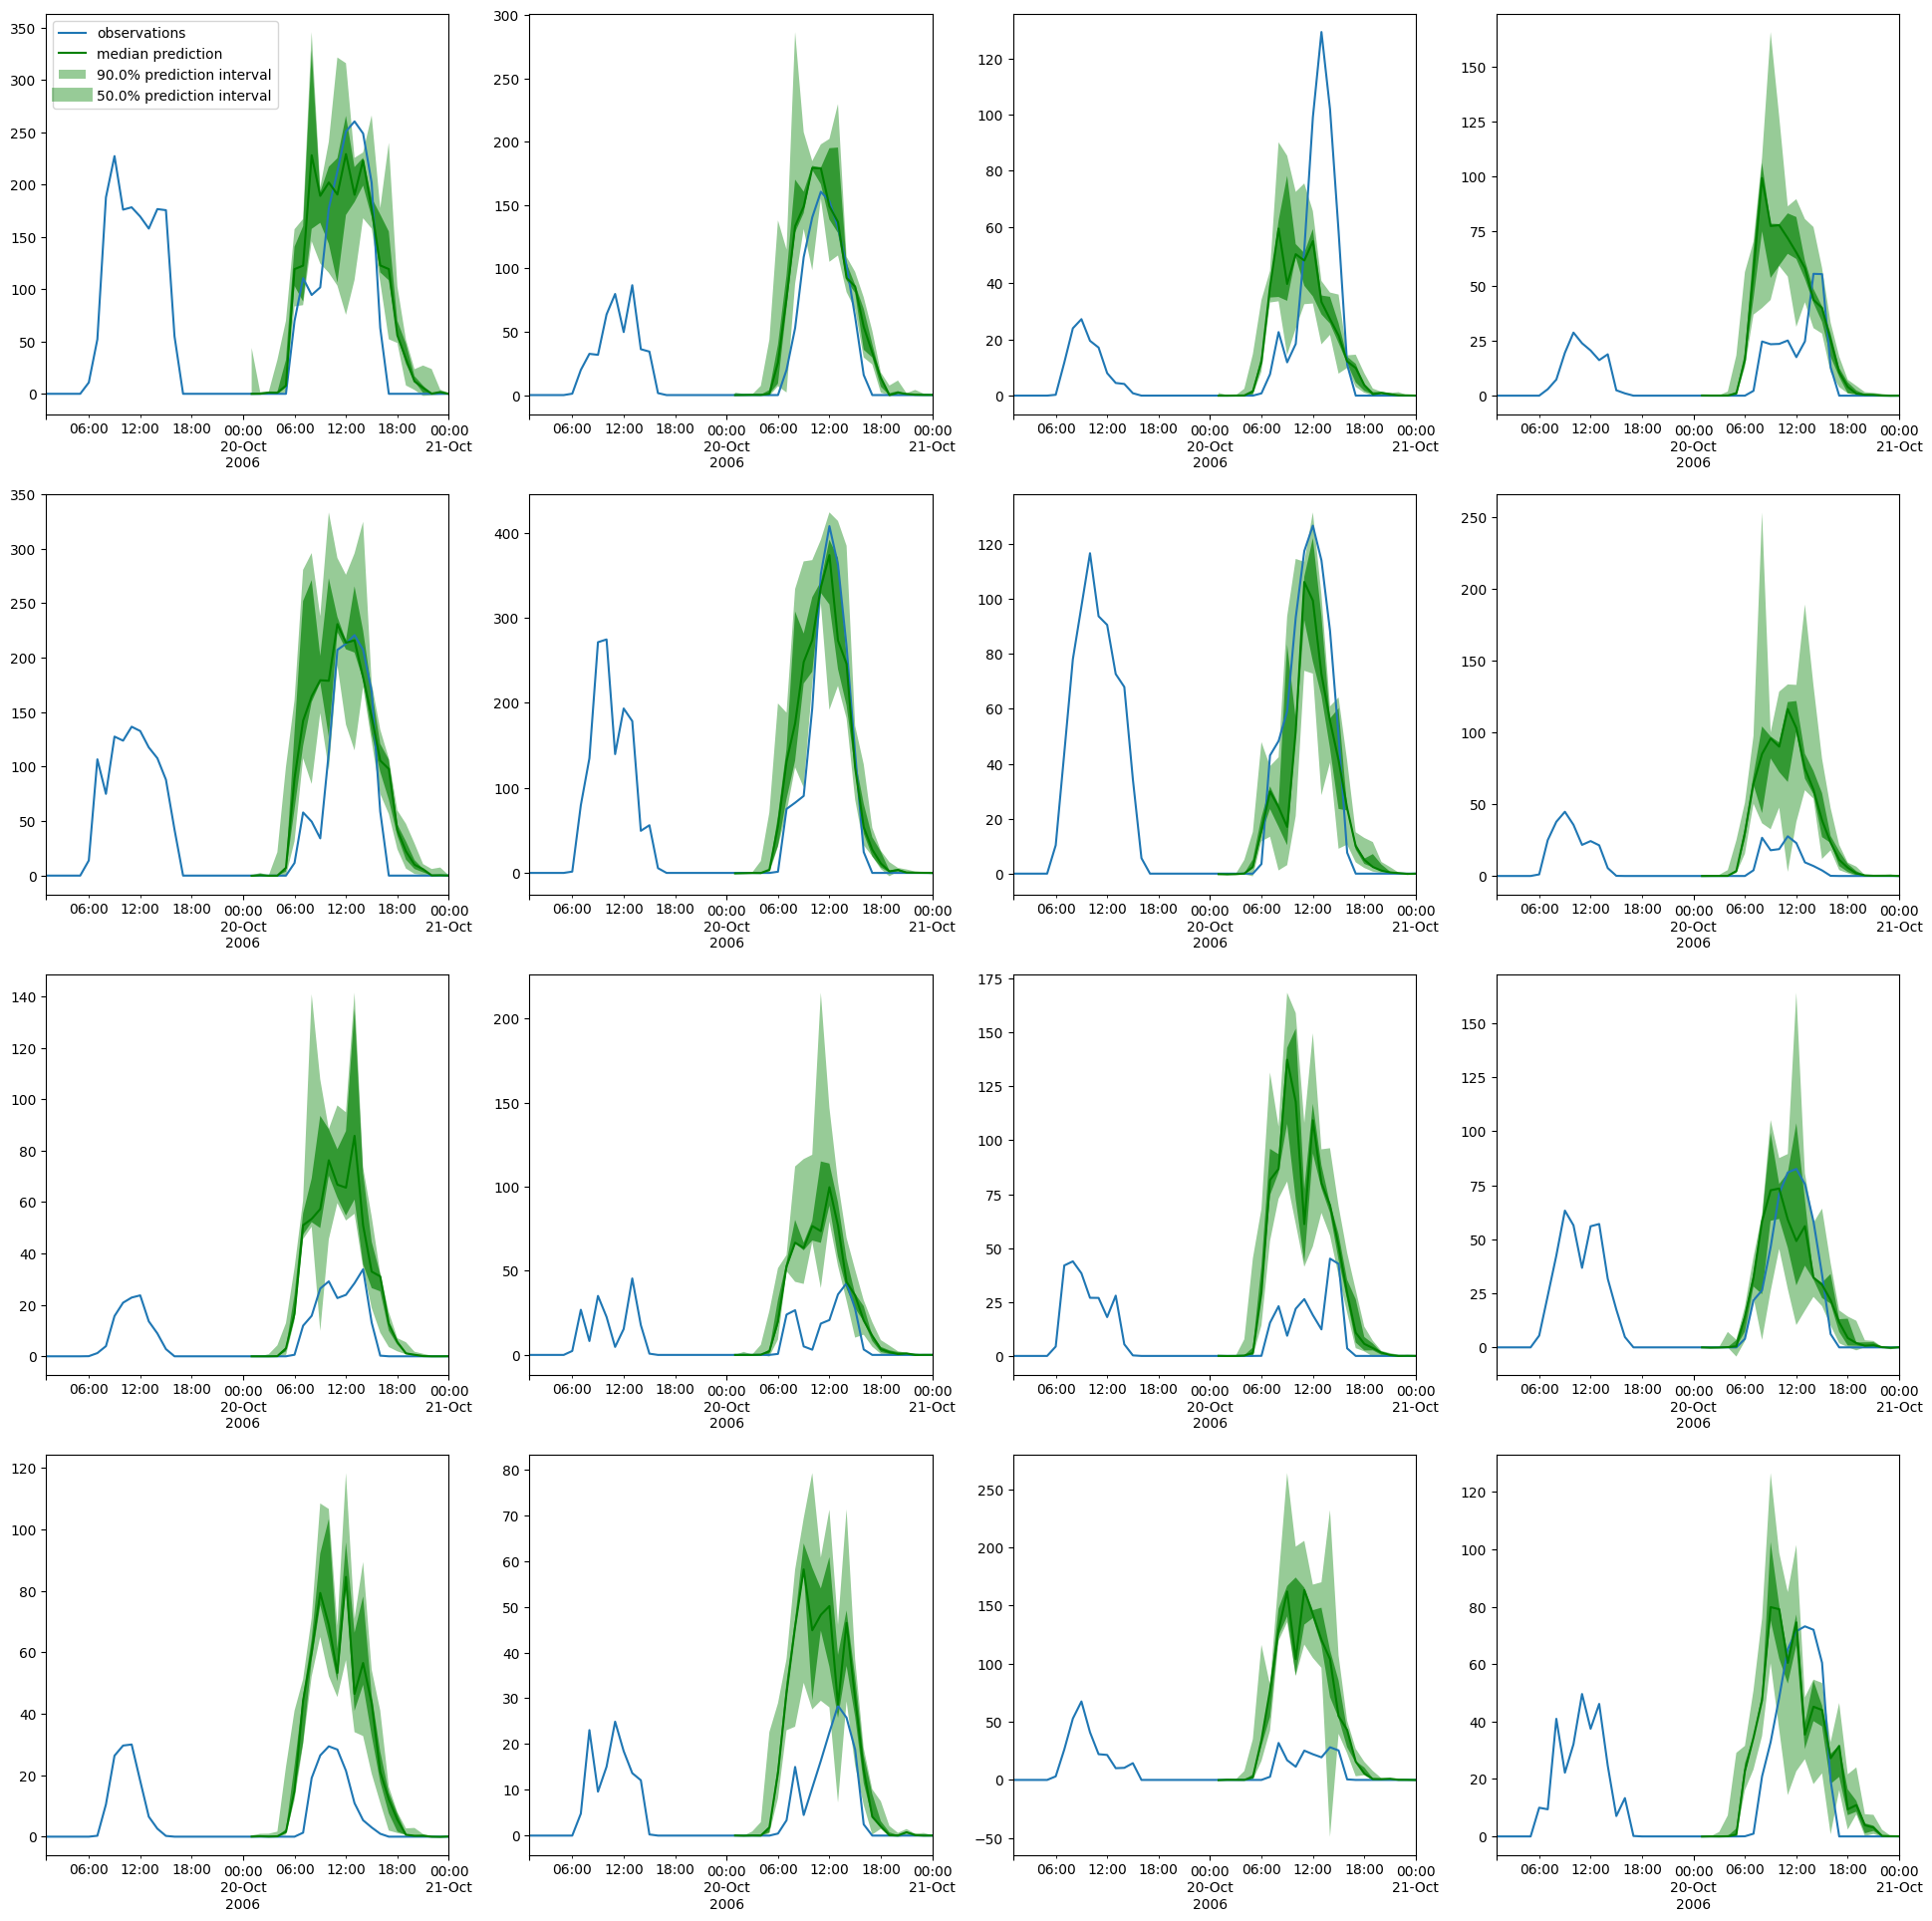

In [7]:
prepare_statistics(
    datasets["solar_nips"]["dataset"], datasets["solar_nips"]["forecasts"],
    datasets["solar_nips"]["targets"], datasets["solar_nips"]["agg_metric"]
)

CRPS: 0.154
CRPS-Sum: 0.0918
----------------------------------------------------------------
ND: 0.179
ND-Sum: 0.1049
----------------------------------------------------------------
NRMSE: 1.8333
NRMSE-Sum: 0.163
----------------------------------------------------------------
MSE: 1924941.414
MSE-Sum: 2083537371.4286
----------------------------------------------------------------


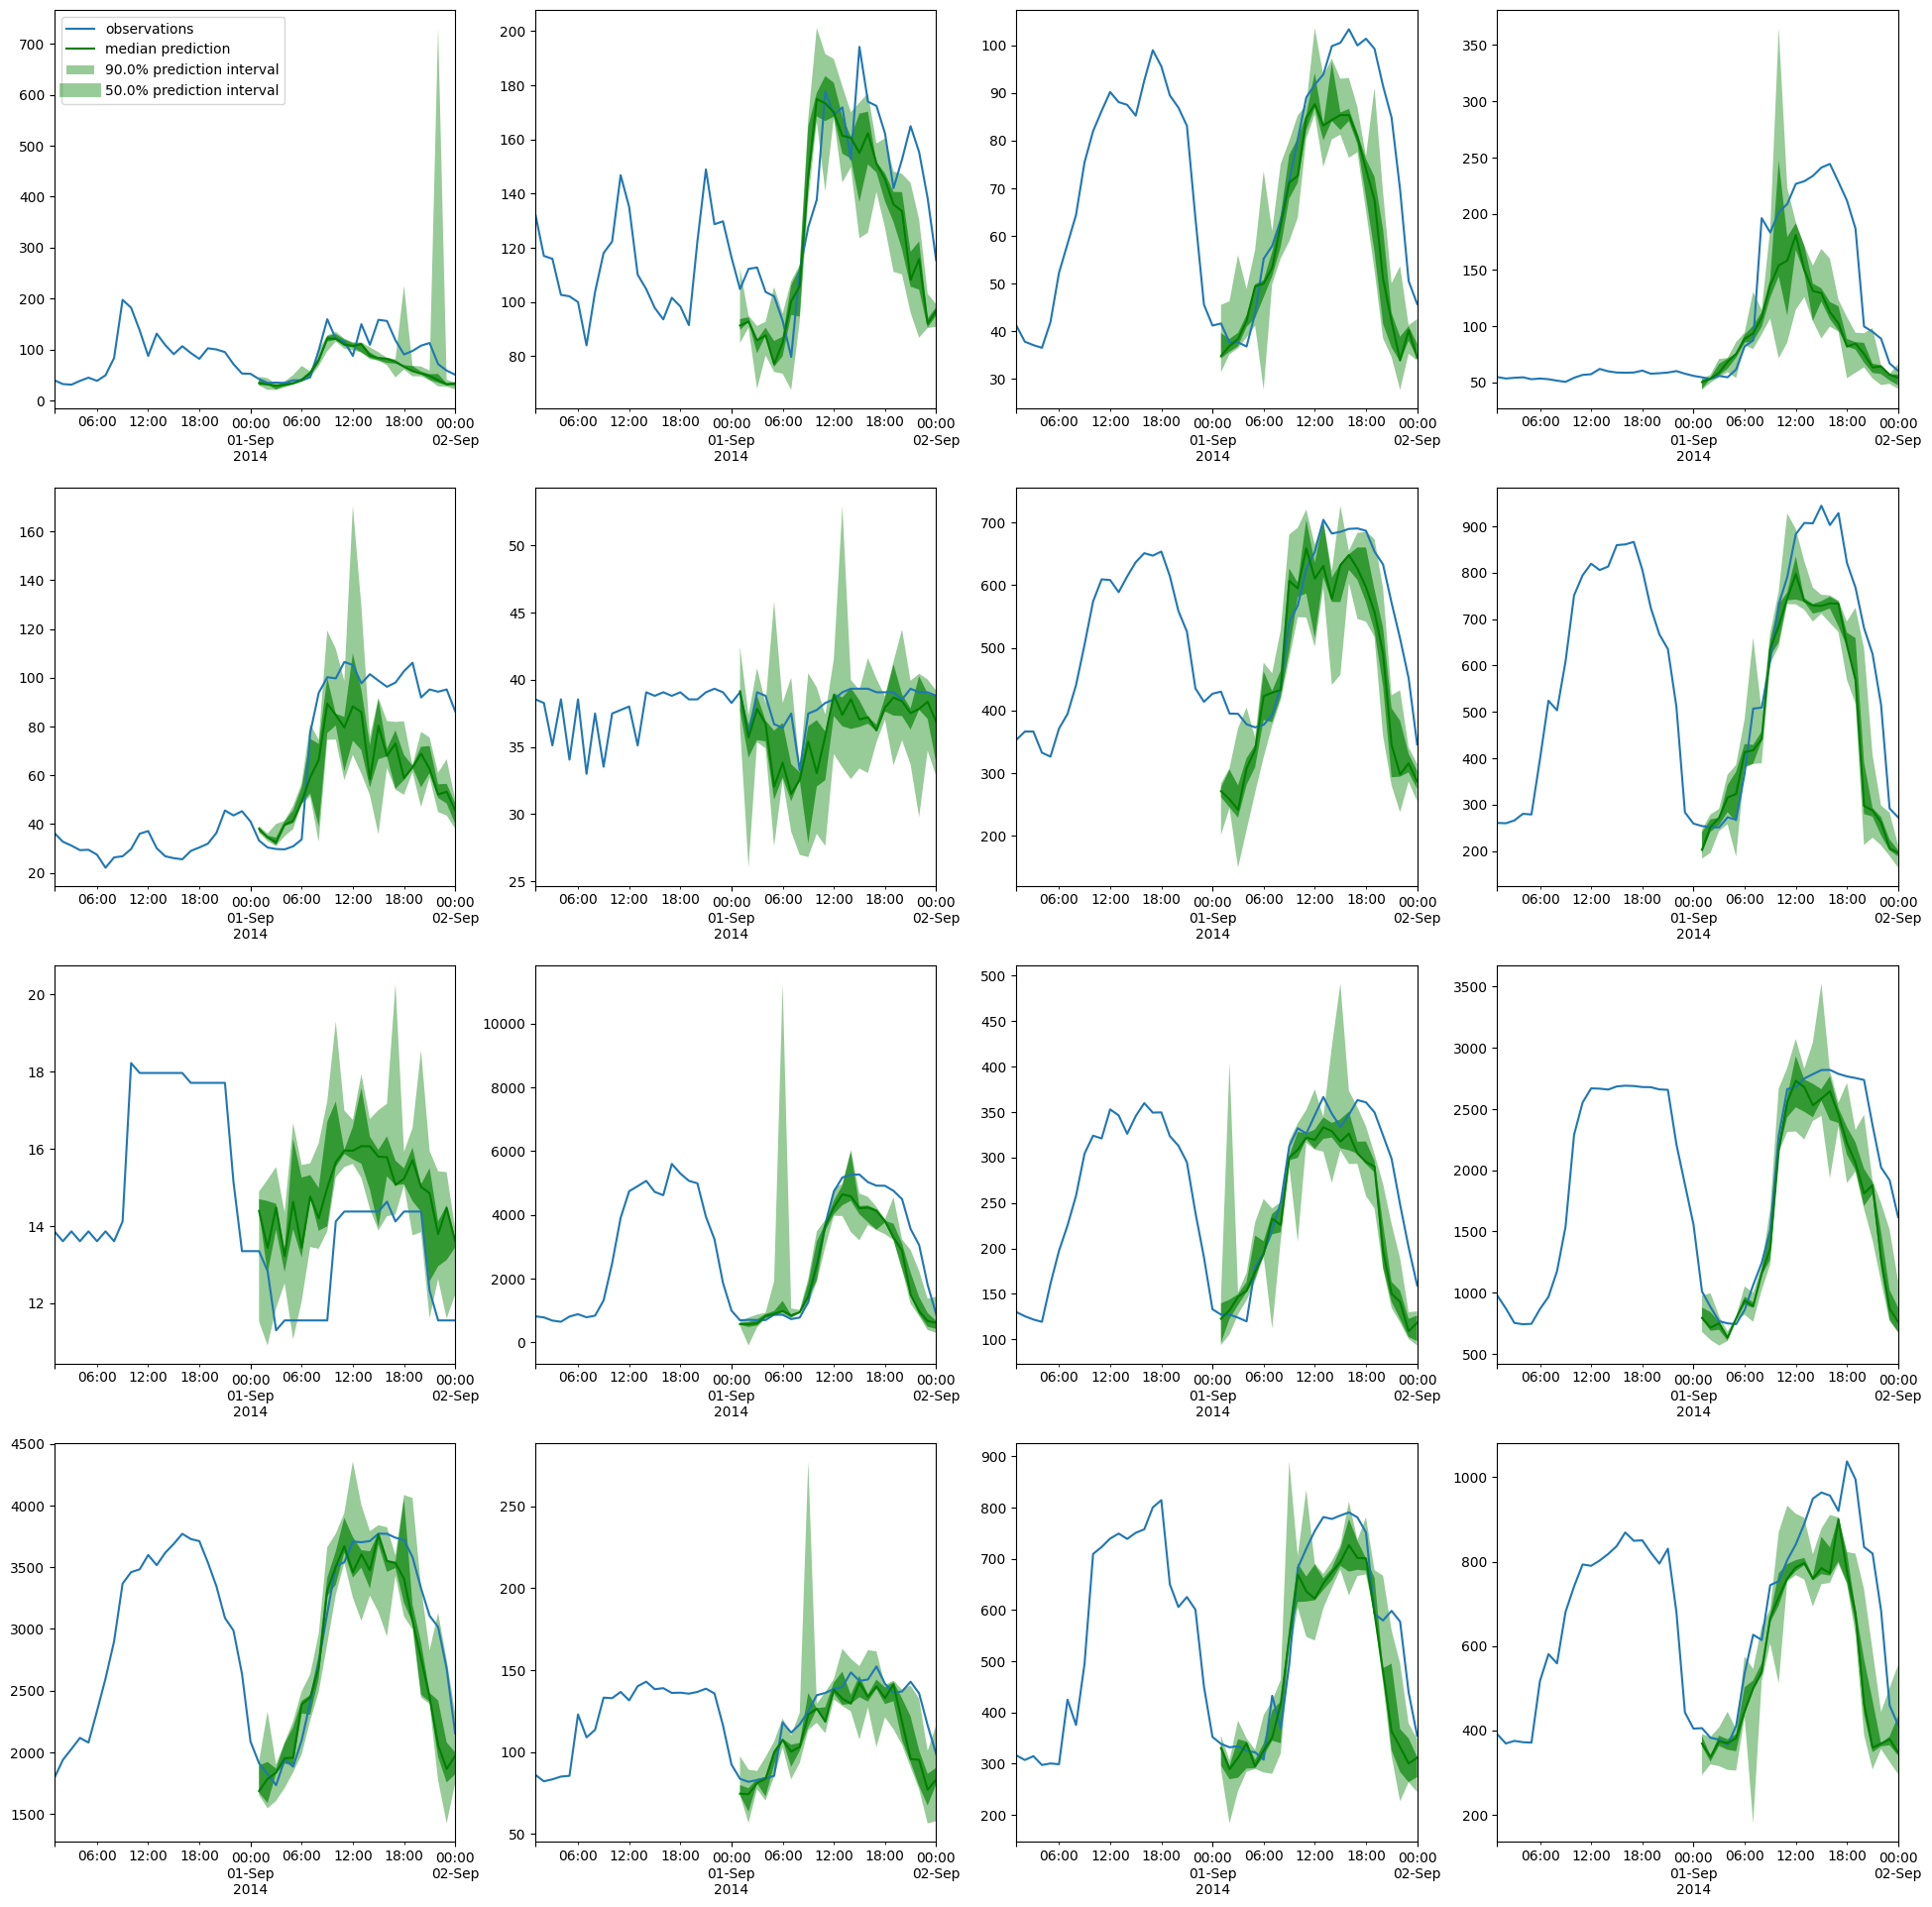

In [8]:
prepare_statistics(
    datasets["electricity_nips"]["dataset"], datasets["electricity_nips"]["forecasts"],
    datasets["electricity_nips"]["targets"], datasets["electricity_nips"]["agg_metric"]
)

CRPS: 0.0475
CRPS-Sum: 0.0501
----------------------------------------------------------------
ND: 0.0544
ND-Sum: 0.054
----------------------------------------------------------------
NRMSE: 0.072
NRMSE-Sum: 0.0558
----------------------------------------------------------------
MSE: 0.0034
MSE-Sum: 0.1317
----------------------------------------------------------------


/opt/homebrew/anaconda3/envs/ysda_env/lib/python3.11/site-packages/gluonts/model/forecast.py:365: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  self._index = pd.period_range(
/opt/homebrew/anaconda3/envs/ysda_env/lib/python3.11/site-packages/gluonts/model/forecast.py:365: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  self._index = pd.period_range(


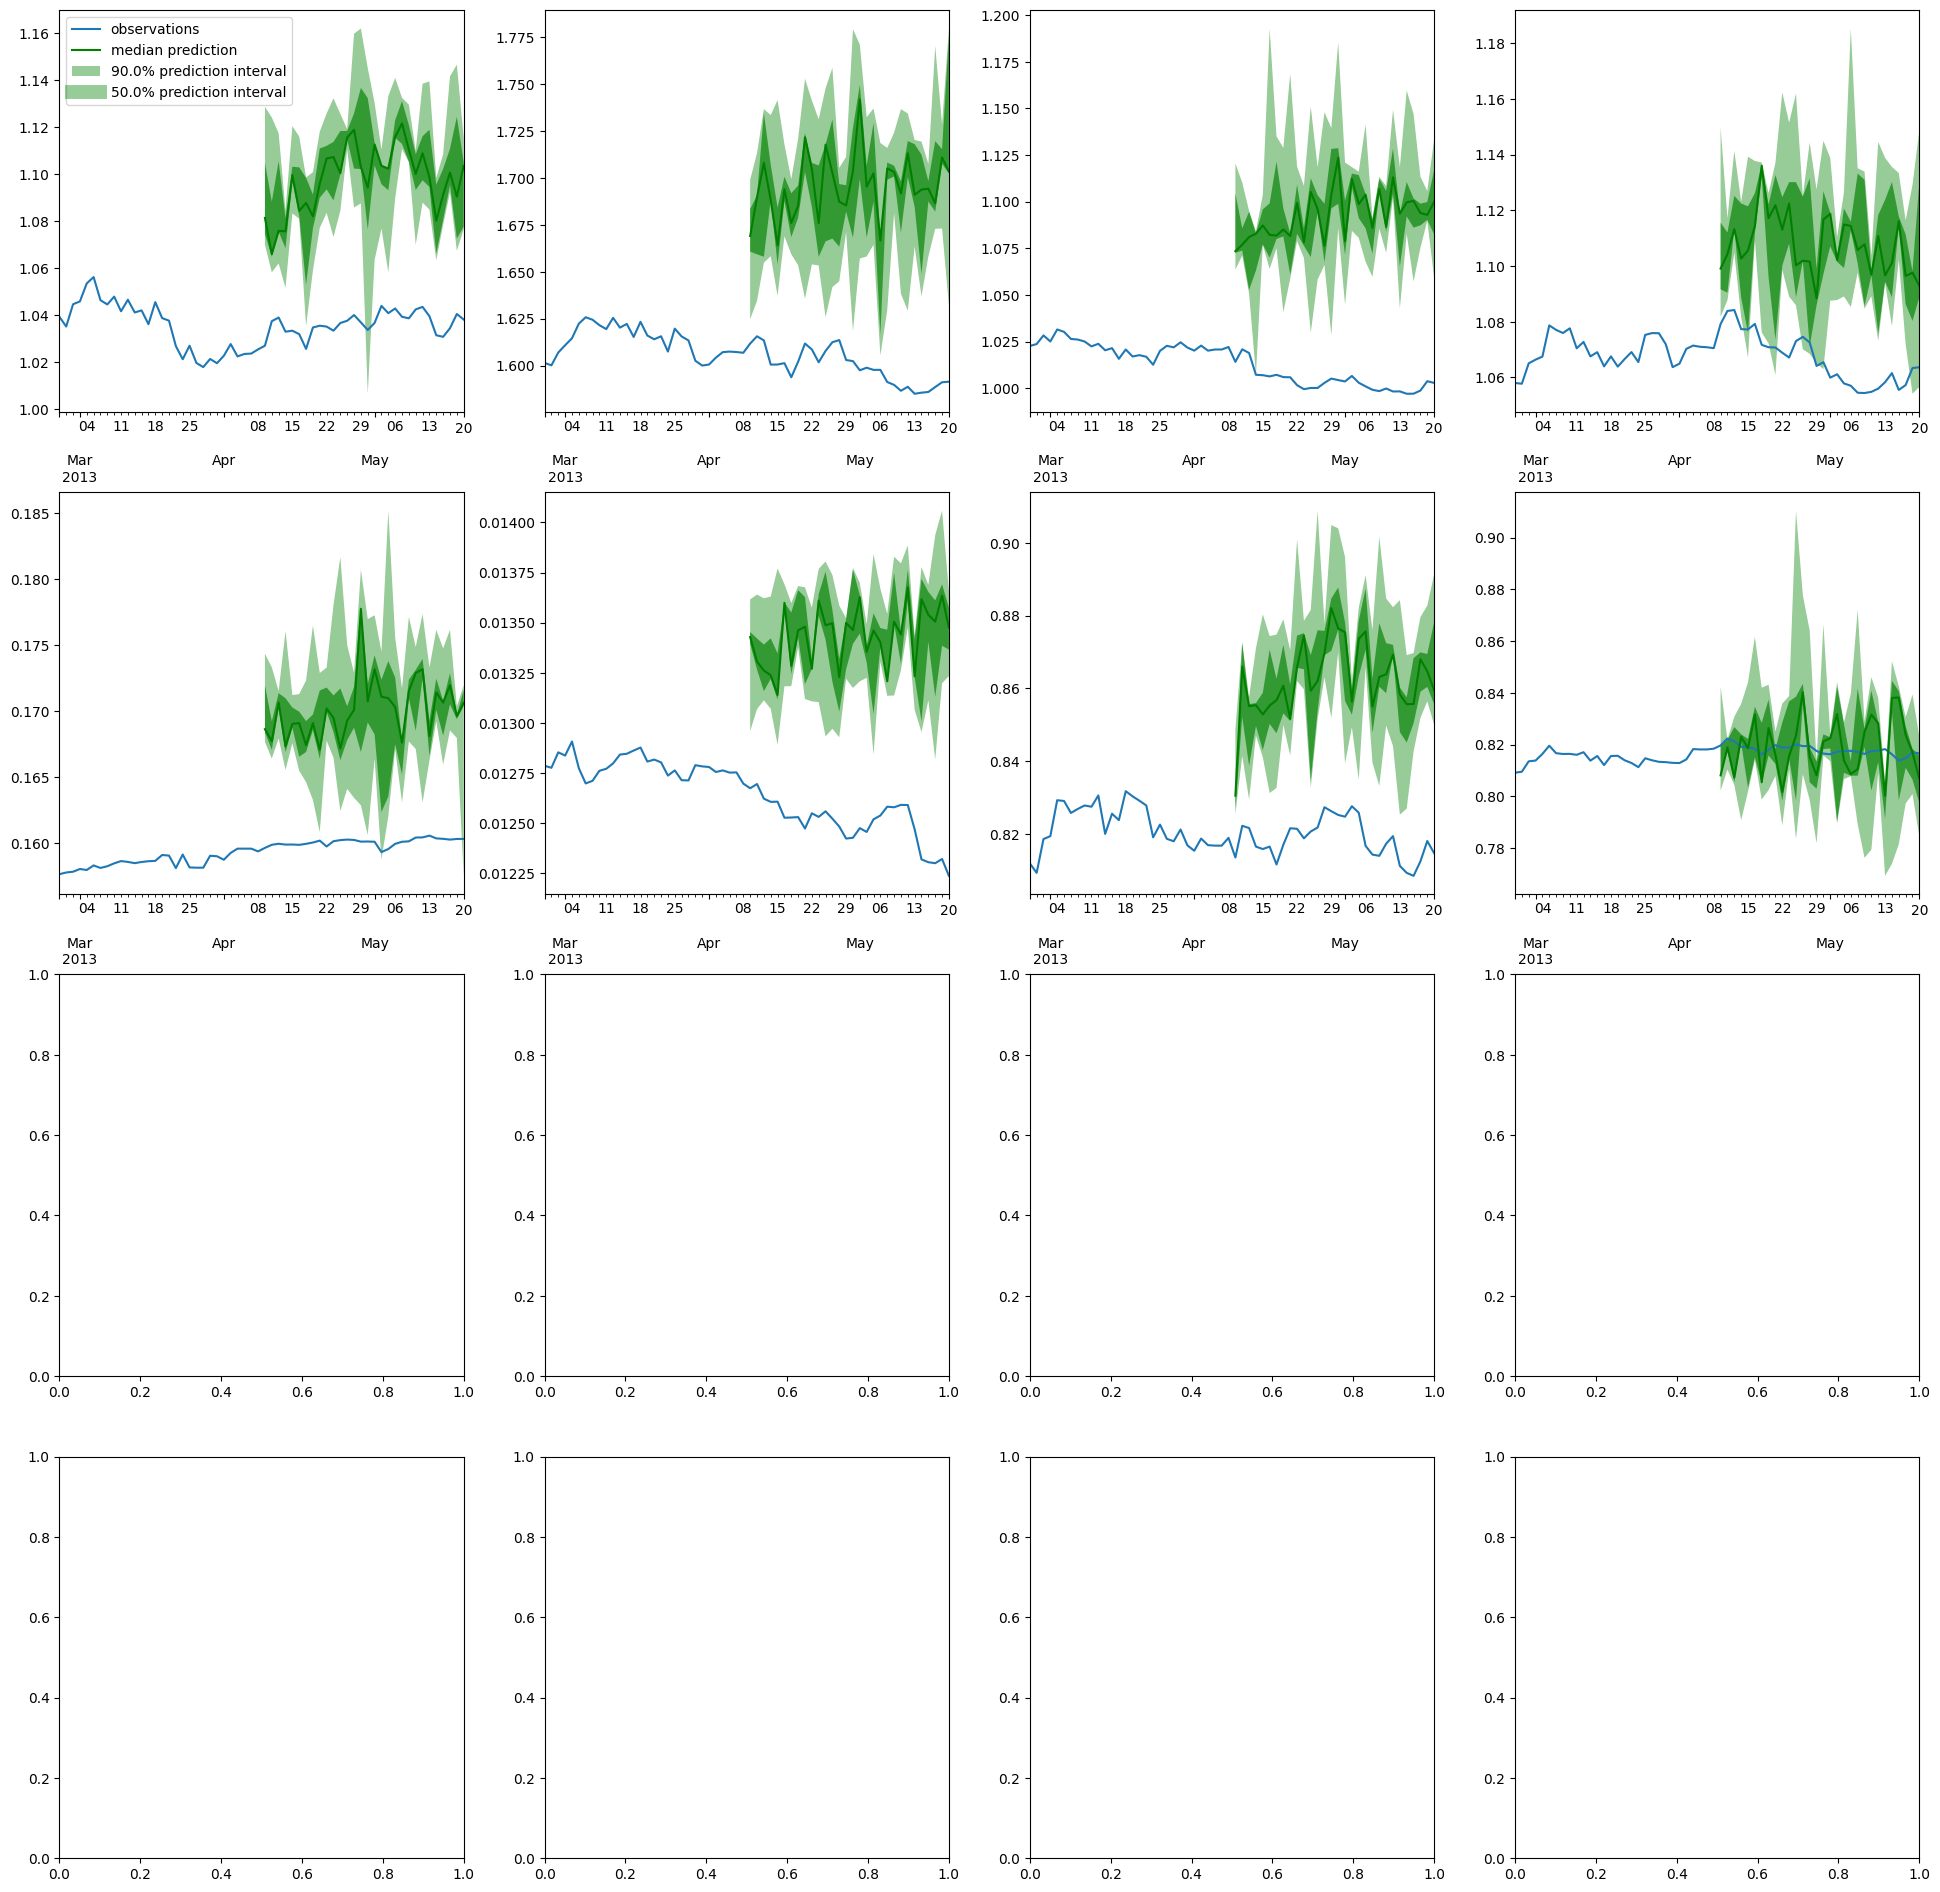

In [9]:
prepare_statistics(
    datasets["exchange_rate_nips"]["dataset"], datasets["exchange_rate_nips"]["forecasts"],
    datasets["exchange_rate_nips"]["targets"], datasets["exchange_rate_nips"]["agg_metric"]
)